# Two-Phase Navier-Stokes with Surface Tension

Let's consider the incompressible Navier-Stokes equations with two immiscible phases and surface tension.

A domain $\Omega \subset \mathbb{R}^2$ is assumed to be separeted into two phases $\Omega_i(t), i=1,2,$ by a sharp interface $\Gamma(t)$.

Find $(u, p)$ and $\Gamma(t)$ s.t.

\begin{align}
\renewcommand{\llbracket}{[\mskip-5mu[}
\renewcommand{\rrbracket}{]\mskip-5mu]}
\renewcommand{\jump}[1]{\llbracket #1 \rrbracket}
\end{align}
\begin{align}
u_t + (u \cdot \nabla u) u - \nu_i \Delta u + \nabla p &= g, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\operatorname{div} u &= 0, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\jump{\rho (\nu n (\nabla u + (\nabla u)^T) n - p ) } &= \sigma \kappa, &\qquad &\text{on } \Gamma(t),\\
\jump{u} &= 0, &\qquad &\text{on } \Gamma(t),\\
\dot x &= u, &\qquad &x \in \Gamma(t),\\
u(0) &= u_0, &\qquad &\text{in } \Omega_i(0), \quad &i&=1,2,\\
\Gamma(0) &= \Gamma_0.
\end{align}

Here, $\nu_i, i=1,2,$ are the kinematic viscositities and $\rho_i, i=1,2,$ the densities of the two phases, $g$ is the gravity, $\sigma$ is the surface tension and $\kappa$ is the signed mean curvature of the interface.

Now, we use Dune-MMesh to compute the result of a rising bubble.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh, trace, skeleton, domainMarker
from dune.fem.view import adaptiveLeafGridView as adaptive

dim = 2
file = "grids/circle.msh"

gridView = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid
igridView = adaptive( hgrid.interfaceGrid )

In [2]:
from dune.ufl import Constant

mu0   = Constant(  1e-2, name="mu0")
mu1   = Constant(  1e-1, name="mu1")
rho0  = Constant(     3, name="rho0")
rho1  = Constant(     1, name="rho1")
sigma = Constant(  3e-1, name="sigma")
g     = Constant(    10, name="g")

dt = 0.001
T  = 1.5

In [3]:
from dune.mmesh import domainMarker

dm = domainMarker(gridView)
mu  = (1-dm) * mu0  + dm * mu1
rho = (1-dm) * rho0 + dm * rho1
nu  = mu / rho

In [4]:
from ufl import *
from dune.fem.space import dglagrange, product

uspace = dglagrange(gridView, dimRange=2, order=2)
pspace = dglagrange(gridView, order=1)

u  = TrialFunction(uspace)
uu = TestFunction(uspace)

p  = TrialFunction(pspace)
pp = TestFunction(pspace)

uh  = uspace.interpolate([0,0], name="velocity")
uh1 = uspace.interpolate([0,0], name="velocity1")
ph  = pspace.interpolate(0, name="pressure")

## Curvature

The mean curvature of the interface times its normal can be computed by
\begin{align*}
\int_{\Gamma(t)} \kappa \cdot \phi + \nabla x \cdot \nabla \phi \ dS = 0, &\qquad &\text{in } \Gamma(t).\\
\end{align*}

In [5]:
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin

kspace = lagrange(igridView, dimRange=dim, order=1)
k  = TrialFunction(kspace)
kk = TestFunction(kspace)

curvature = kspace.interpolate([0]*dim, name="curvature")

ix = SpatialCoordinate(kspace)
C  = inner(k, kk) * dx
C -= inner(grad(ix), grad(kk)) * dx
kscheme = galerkin([C == 0])
res = kscheme.solve(curvature)

## Navier-Stokes equations

As solution strategy, we use an operator split known as Chorin's method.

In [6]:
from dune.mmesh import interfaceIndicator
from dune.fem.scheme import galerkin
from dune.ufl import Constant

x = SpatialCoordinate(pspace)
n = FacetNormal(pspace)
I = interfaceIndicator(igridView)

uBC = as_vector([0,0])

tau  = Constant(dt, name="tau")
penu = Constant(1e3, name="penaltyu")
penp = Constant(1e3, name="penaltyp")

a1  = inner(u - uh, uu) / tau * dx
a1 += inner(grad(uh) * uh, uu) * dx
a1 += nu * inner(grad(u), grad(uu)) * dx
a1 += g * uu[1] * dx
a1 += penu * inner(jump(u), jump(uu)) * dS
a1 += penu * inner(u - uBC, uu) * ds

a2  = inner(grad(p), grad(pp)) * dx
a2 += div(uh1) * pp / tau * dx
a2 += penp * jump(p * rho) * jump(pp) * dS
a2 += 1e-6 * p * pp * dx

S = sigma * inner(avg(skeleton(curvature)), n('+'))
S += dot(jump(mu * (nabla_grad(uh1) + nabla_grad(uh1).T), n('+')), n('+'))
a2 -= penp * S * jump(pp) * I * dS

a3  = inner(u - uh1, uu) * dx
a3 += tau * inner(grad(ph), uu) * dx
a3 += penu * inner(jump(u), jump(uu)) * dS
a3 += penu * inner(u - uBC, uu) * ds

A1 = galerkin([a1 == 0], solver=('suitesparse', 'umfpack'))
A2 = galerkin([a2 == 0], solver=('suitesparse', 'umfpack'))
A3 = galerkin([a3 == 0], solver=('suitesparse', 'umfpack'))

## Moving

We can obtain the interface movement from the trace of the bulk velocity $u$.

In [7]:
import numpy as np

def getShifts(uh):
    mapper = igridView.hierarchicalGrid.leafView.indexSet
    shifts = np.zeros((igridView.size(dim-1), dim))
    for e in igridView.elements:
        for v in e.subEntities(igridView.dimension):
            x = e.geometry.toLocal(v.geometry.center)
            shifts[ mapper.index(v) ] += 0.5 * trace(uh)(e, x)
    return shifts

## Timeloop

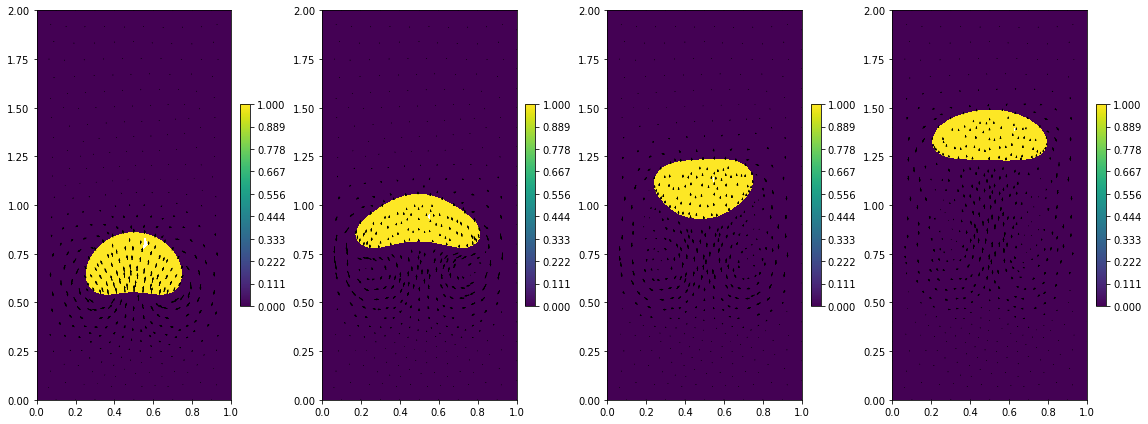

In [8]:
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as plt

N = 4
i = 0
fig, axs = plt.subplots(1, N, figsize=(16,6))

uh.interpolate([0,0])
ph.interpolate(0)

step = 0
t = 0
while t < T+dt:
    kscheme.solve(curvature)

    A1.solve(target=uh1)
    A2.solve(target=ph)
    A3.solve(target=uh)

    hgrid.markElements()
    hgrid.ensureInterfaceMovement( 2*dt*getShifts(uh) )
    adapt([uh, uh1, ph, dm])
    adapt([curvature])
    hgrid.moveInterface( dt*getShifts(uh) )
    
    t += dt
    gridView.writeVTK("twophase-"+str(step), pointdata=[ph, uh], celldata=[dm],
                      nonconforming=True, subsampling=1)
    igridView.writeVTK("interface-"+str(step), pointdata=[curvature])
    step += 1
    
    if int(N * t/T) > i:
        plot(dm, figure=(fig, axs[i]), gridLines=None)
        plot(uh, figure=(fig, axs[i]), gridLines=None, vectors=[0,1])
        i += 1